In [2]:
import os

folders_path = 'C:/Users/david.chen/OneDrive/文件/research/with_merri_su/chineseMedicineDataAnalysis/超音波影像/'
folder_path1 = os.listdir(folders_path)[1]
folder_path2 = os.listdir(folders_path + folder_path1)[1]

In [3]:
image_dirs = [folders_path + folder_path1 + '/' + folder_path2 + '/' + p for p in os.listdir(folders_path + folder_path1 + '/' + folder_path2)]

In [4]:
def extract_image_directory_data_pair(dir_name):
    side = None
    if "σ╖ªµëï" in dir_name:
        side = 2
    elif "σÅ│µëï" in dir_name:
        side = 1
    if side is None:
        return None
    else:
        # find the digit in the directory name
        digit = ""
        for c in dir_name:
            if c.isdigit():
                digit += c
        digit = int(digit)
        return (side, digit, dir_name)

In [5]:
data_pairs = [extract_image_directory_data_pair(dir) for dir in image_dirs]

In [6]:
import pandas as pd
import numpy as np

# read particular tab in the xlsx file
df = pd.read_excel("中醫數據(排除).xlsx", sheet_name="診所病人")
df = df.ffill()

In [7]:
data_cols = [
    "PSV(cm/s)",
    "EDV(cm/s)",
    "PI",
    "RI",
    "VTI",
    "TAV Max",
    "SB",
    "SD",
    "ACCL",
    "ACCT"
]


In [8]:
import matplotlib.pyplot as plt
import cv2

# find what 脈象 correspond to which frame in each image directory
def preprocess_data(data_pair):
    side, digit, dir_name = data_pair
    curdf = df[np.logical_and(df["病例編號"] == digit, df["左右手.1"] == side)]
    # read in all the images into a numpy array
    image_files = os.listdir(dir_name)
    image_files = [dir_name + '/' + f for f in image_files if f.endswith(".PNG")]
    images = np.array([cv2.resize(cv2.resize(plt.imread(f), (224,224))[110:,70:170,:], (224,224)) for f in image_files])
    images2 = np.array([cv2.resize(cv2.resize(plt.imread(f), (224,224))[25:110,70:170,:], (224,224)) for f in image_files])
    # find the 脈象分級
    pulse = curdf["脈象分級(浮/中/沉)"].values
    data_vals = curdf[data_cols].values
    if len(images) == 0:
        return np.zeros((0,224,224,3)), np.zeros((0,224,224,3)), np.zeros(0), np.zeros((0, len(data_cols)))
    return images, images2, pulse, data_vals

data_image_labels = [preprocess_data(data_pair) for data_pair in data_pairs if data_pair is not None]
imagesAll = np.concatenate([images for images, _, _,_ in data_image_labels])
images2All = np.concatenate([images for _,images, _, _ in data_image_labels])
labelsAll = np.concatenate([labels for _, _, labels, _ in data_image_labels])
dataAll = np.concatenate([data for _, _, _, data in data_image_labels])

In [9]:
labels1 = np.array([1 if "浮" in v else 0 for v in labelsAll])
labels2 = np.array([1 if "中" in v else 0 for v in labelsAll])
labels3 = np.array([1 if "沉" in v else 0 for v in labelsAll])

In [10]:
np.unique(labels3, return_counts=True)

(array([0, 1]), array([295, 127], dtype=int64))

In [11]:
# build a cnn model with resnet50 that reads in the images and outputts the pulse

from tensorflow.keras.applications import ResNet50, ConvNeXtBase
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

resnetLayer = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
resnetLayer.trainable = False

from tensorflow.keras.layers import Concatenate

def denoise_image(img):
    import bm3d
    denoised_image = bm3d.bm3d(img, sigma_psd=30/255, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)
    return denoised_image

def build_model(input1_s, input2_s, input3_s, output_s):
    # First input: Image
    input1 = Input(shape=input1_s)
    x1 = resnetLayer(input1)
    x1 = Flatten()(x1)
    x1 = Dense(1024, activation='relu')(x1)
    x1 = Dropout(0.5)(x1)

    # Second input: Image
    input2 = Input(shape=input2_s)
    x2 = resnetLayer(input2)
    x2 = Flatten()(x2)
    x2 = Dense(1024, activation='relu')(x2)
    x2 = Dropout(0.5)(x2)

    # Third input: Data vector
    input3 = Input(shape=input3_s)
    y = Dense(512, activation='relu')(input3)
    y = Dropout(0.5)(y)

    # Merge inputs
    merged = Concatenate()([x1, x2, y])

    # Output layer
    output = Dense(output_s, activation='sigmoid')(merged)

    # Build and compile model
    model = Model(inputs=[input1, input2, input3], outputs=output)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Call the function
model1 = build_model((224, 224, 3), (224, 224, 3), (dataAll.shape[1],), 1)
model2 = build_model((224, 224, 3), (224, 224, 3), (dataAll.shape[1],), 1)
model3 = build_model((224, 224, 3), (224, 224, 3), (dataAll.shape[1],), 1)


# denoise the images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


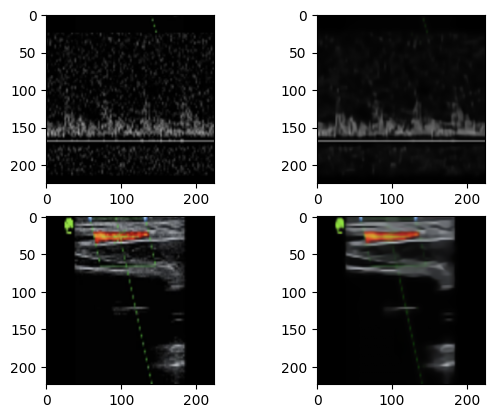

In [12]:
import cv2
import matplotlib.pyplot as plt

origImage = imagesAll[0,:,:,:]
origImage2 = images2All[0,:,:,:]
fig, ax = plt.subplots(2,2)
ax[0,0].imshow(origImage)
ax[0,1].imshow(denoise_image(origImage))
ax[1,0].imshow(origImage2)
ax[1,1].imshow(denoise_image(origImage2))
plt.show()

In [28]:
denoisedImagesAll = [] 
for i in range(len(imagesAll)):
    print(i/ len(imagesAll))
    img = imagesAll[i,:,:,:]
    denoisedImagesAll.append(denoise_image(img))
denoisedImagesAll = np.array(denoisedImagesAll)

denoisedImages2All = [] 
for i in range(len(images2All)): 
    print(i/ len(images2All))
    img = images2All[i,:,:,:]
    denoisedImages2All.append(denoise_image(img))
denoisedImages2All = np.array(denoisedImages2All)

0.0
0.0026954177897574125
0.005390835579514825
0.008086253369272238
0.01078167115902965
0.013477088948787063
0.016172506738544475
0.018867924528301886
0.0215633423180593
0.02425876010781671
0.026954177897574125
0.029649595687331536
0.03234501347708895
0.03504043126684636
0.03773584905660377
0.04043126684636118
0.0431266846361186
0.04582210242587601
0.04851752021563342
0.05121293800539083
0.05390835579514825
0.05660377358490566
0.05929919137466307
0.06199460916442048
0.0646900269541779
0.0673854447439353
0.07008086253369272
0.07277628032345014
0.07547169811320754
0.07816711590296496
0.08086253369272237
0.08355795148247978
0.0862533692722372
0.0889487870619946
0.09164420485175202
0.09433962264150944
0.09703504043126684
0.09973045822102426
0.10242587601078167
0.10512129380053908
0.1078167115902965
0.1105121293800539
0.11320754716981132
0.11590296495956873
0.11859838274932614
0.12129380053908356
0.12398921832884097
0.12668463611859837
0.1293800539083558
0.1320754716981132
0.134770889487870

In [29]:
model1.fit([denoisedImagesAll, denoisedImages2All, dataAll], labels1, epochs=10, batch_size=32, validation_split=0.3)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - accuracy: 0.5230 - loss: 32.6004 - val_accuracy: 0.5446 - val_loss: 3.2312
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.5440 - loss: 7.6058 - val_accuracy: 0.4375 - val_loss: 1.3710
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.4883 - loss: 6.5794 - val_accuracy: 0.5536 - val_loss: 1.8704
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.5219 - loss: 5.2548 - val_accuracy: 0.5536 - val_loss: 1.5892
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.5377 - loss: 5.8227 - val_accuracy: 0.5446 - val_loss: 0.7494
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.4814 - loss: 5.0421 - val_accuracy: 0.5536 - val_loss: 3.4357
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.5826 - loss: 5.3028 - val_accuracy: 0.4464 - val_loss: 1.0287
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.5133 - loss: 4.6151 - val_accuracy: 0.5536 - val_loss: 2.2582
Epoch 9

In [30]:
model2.fit([denoisedImagesAll, denoisedImages2All, dataAll], labels2, epochs=10, batch_size=32, validation_split=0.3)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.9452 - loss: 5.4876 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9311 - loss: 4.2285 - val_accuracy: 1.0000 - val_loss: 6.1776e-17
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.9704 - loss: 1.0320 - val_accuracy: 1.0000 - val_loss: 4.4897e-22
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9411 - loss: 2.1160 - val_accuracy: 1.0000 - val_loss: 1.4946e-13
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.9553 - loss: 0.8269 - val_accuracy: 1.0000 - val_loss: 1.9278e-14
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9346 - loss: 1.0668 - val_accuracy: 1.0000 - val_loss: 4.9983e-17
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9358 - loss: 1.2861 - val_accuracy: 1.0000 - val_loss: 3.1168e-13
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.9455 - loss: 0.7470 - val_accuracy: 1.0000

In [31]:
model3.fit([denoisedImagesAll, denoisedImages2All, dataAll], labels3, epochs=10, batch_size=32, validation_split=0.3)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.5026 - loss: 31.3425 - val_accuracy: 0.8482 - val_loss: 0.3394
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.4490 - loss: 7.4632 - val_accuracy: 0.3839 - val_loss: 1.0372
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.4657 - loss: 6.5580 - val_accuracy: 0.0089 - val_loss: 2.1389
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.5479 - loss: 6.2247 - val_accuracy: 0.9911 - val_loss: 0.0952
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.5430 - loss: 4.8264 - val_accuracy: 0.6964 - val_loss: 0.6760
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.4859 - loss: 6.3015 - val_accuracy: 0.0893 - val_loss: 1.2648
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.4461 - loss: 4.7084 - val_accuracy: 0.3929 - val_loss: 1.0205
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - accuracy: 0.6161 - loss: 3.3831 - val_accuracy: 1.0000 - val_loss: 0.0358
Epoch 9